In [27]:
import os
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier

In [2]:
import logging
import warnings
import os
import contextlib

warnings.filterwarnings("ignore")

# Supervised Classification models

In [28]:
os.makedirs('figures', exist_ok=True)

In [3]:
# Load data
data = pd.read_csv("clinical_data.csv")

In [4]:
# Step 1: Handle missing values (imputing gave low accuracies)
data.dropna(inplace=True)
data = data.drop(columns=["patient_id", "study_id", "histology"])
data = data[data["race"] != "other"]

In [5]:
# Define features and target variable
X = data.drop(columns=["survival_status", "survival_months"])
y = data["survival_status"]

In [6]:
# Step 2: Feature engineering
categorical_features = ['sex', 'race', 'stage', 'egfr_mutated', 'kras_mutated', 'tp53_mutated']
numerical_features = ['age']

In [7]:
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [8]:
# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)

In [9]:
# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X

,sex,age,race,smoking_status,stage,egfr_mutated,kras_mutated,tp53_mutated
0,female,60.0,caucasian,smoker,stage_1,egfr_neg,kras_neg,tp53_neg
1,female,51.0,caucasian,smoker,stage_1,egfr_neg,kras_neg,tp53_pos
2,female,61.0,african_american,smoker,stage_1,egfr_pos,kras_neg,tp53_pos
3,male,53.0,african_american,smoker,stage_3,egfr_neg,kras_neg,tp53_neg
4,male,58.0,caucasian,smoker,stage_1,egfr_neg,kras_pos,tp53_pos
...,...,...,...,...,...,...,...,...
962,female,82.0,caucasian,non_smoker,stage_1,egfr_pos,kras_neg,tp53_neg
965,female,75.0,caucasian,non_smoker,stage_2,egfr_neg,kras_neg,tp53_neg
966,female,73.0,caucasian,non_smoker,stage_2,egfr_neg,kras_neg,tp53_neg
967,female,83.0,caucasian,non_smoker,stage_1,egfr_neg,kras_neg,tp53_neg


In [11]:
# Step 4: Define models and hyperparameter tuning with Optuna
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [12]:
# Define pipelines for each model
def create_pipeline(model):
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

In [13]:
# Define objective function for Optuna tuning
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

def objective_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, scale_pos_weight=2, random_state=42, use_label_encoder=False, eval_metric='logloss')
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

def objective_svm(trial):
    C = trial.suggest_float("C", 0.1, 10.0)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
    model = SVC(C=C, kernel=kernel, probability=True, class_weight='balanced', random_state=42)
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

def objective_catboost(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    depth = trial.suggest_int("depth", 3, 10)
    model = CatBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, depth=depth, class_weights=[1, 2], random_state=42, verbose=0)
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

def objective_logreg(trial):
    C = trial.suggest_float("C", 0.1, 10.0)
    model = LogisticRegression(C=C, penalty='l2', class_weight='balanced', random_state=42)
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

def objective_bagging(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 150)
    max_depth = trial.suggest_int("max_depth", 3, 6)
    base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model = BaggingClassifier(estimator=base_estimator, n_estimators=n_estimators, random_state=42)
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

# Objective function for Naive Bayes
def objective_nb(trial):
    alpha = trial.suggest_float("alpha", 0.1, 1.0)
    if all(feature.startswith('sex') or feature.startswith('race') or feature.startswith('stage') or feature.startswith('egfr_mutated') or feature.startswith('kras_mutated') or feature.startswith('tp53_mutated') for feature in X.columns):
        model = CategoricalNB(alpha=alpha)
    else:
        model = GaussianNB()
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(scores)

### Step 4: Optimize Models

In [14]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # Suppress Optuna logs

In [15]:
# Hyperparameter tuning and model evaluation
cv_results = {}

In [16]:
# Random Forest
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)
print("Best hyperparameters for Random Forest:", study_rf.best_params)
rf_model = RandomForestClassifier(**study_rf.best_params, class_weight='balanced', random_state=42)
rf_pipeline = create_pipeline(rf_model)
rf_pipeline.fit(X_train, y_train)
rf_y_pred = rf_pipeline.predict(X_test)
rf_y_prob = rf_pipeline.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_y_prob)

Best hyperparameters for Random Forest: {'n_estimators': 177, 'max_depth': 8}


In [17]:
# XGBoost
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)
print("Best hyperparameters for XGBoost:", study_xgb.best_params)
xgb_model = XGBClassifier(**study_xgb.best_params, scale_pos_weight=2, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_pipeline = create_pipeline(xgb_model)
xgb_pipeline.fit(X_train, y_train)
xgb_y_pred = xgb_pipeline.predict(X_test)
xgb_y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_y_prob)


Best hyperparameters for XGBoost: {'n_estimators': 224, 'learning_rate': 0.1355694463556239, 'max_depth': 15}


In [18]:
# SVM
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_svm, n_trials=50)
print("Best hyperparameters for SVM:", study_svm.best_params)
svm_model = SVC(**study_svm.best_params, probability=True, class_weight='balanced', random_state=42)
svm_pipeline = create_pipeline(svm_model)
svm_pipeline.fit(X_train, y_train)
svm_y_pred = svm_pipeline.predict(X_test)
svm_y_prob = svm_pipeline.predict_proba(X_test)[:, 1]
svm_auc = roc_auc_score(y_test, svm_y_prob)

Best hyperparameters for SVM: {'C': 0.6464592042707846, 'kernel': 'poly'}


In [19]:
# CatBoost
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=50)
print("Best hyperparameters for CatBoost:", study_catboost.best_params)
catboost_model = CatBoostClassifier(**study_catboost.best_params, class_weights=[1, 2], random_state=42, verbose=0)
catboost_pipeline = create_pipeline(catboost_model)
catboost_pipeline.fit(X_train, y_train)
catboost_y_pred = catboost_pipeline.predict(X_test)
catboost_y_prob = catboost_pipeline.predict_proba(X_test)[:, 1]
catboost_auc = roc_auc_score(y_test, catboost_y_prob)

Best hyperparameters for CatBoost: {'n_estimators': 299, 'learning_rate': 0.27119428436757176, 'depth': 7}


In [20]:
# Logistic Regression
study_logreg = optuna.create_study(direction="maximize")
study_logreg.optimize(objective_logreg, n_trials=50)
logreg_model = LogisticRegression(**study_logreg.best_params, class_weight='balanced', random_state=42)
logreg_pipeline = create_pipeline(logreg_model)
logreg_pipeline.fit(X_train, y_train)
logreg_y_pred = logreg_pipeline.predict(X_test)
logreg_y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_y_prob)

In [21]:
# Bagging Classifier
study_bagging = optuna.create_study(direction="maximize")
study_bagging.optimize(objective_bagging, n_trials=50)
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=study_bagging.best_params['max_depth'], random_state=42), n_estimators=study_bagging.best_params['n_estimators'], random_state=42)
bagging_pipeline = create_pipeline(bagging_model)
bagging_pipeline.fit(X_train, y_train)
bagging_y_pred = bagging_pipeline.predict(X_test)
bagging_y_prob = bagging_pipeline.predict_proba(X_test)[:, 1]
bagging_auc = roc_auc_score(y_test, bagging_y_prob)

In [22]:
#Naive Bayes
study_nb = optuna.create_study(direction="maximize")
study_nb.optimize(objective_nb, n_trials=50)
if all(feature.startswith('sex') or feature.startswith('race') or feature.startswith('stage') or feature.startswith('egfr_mutated') or feature.startswith('kras_mutated') or feature.startswith('tp53_mutated') for feature in X.columns):
    nb_model = CategoricalNB(alpha=study_nb.best_params['alpha'])
else:
    nb_model = GaussianNB()
nb_pipeline = create_pipeline(nb_model)
nb_pipeline.fit(X_train, y_train)
nb_y_pred = nb_pipeline.predict(X_test)
nb_y_prob = nb_pipeline.predict_proba(X_test)[:, 1]
nb_auc = roc_auc_score(y_test, nb_y_prob)

In [23]:
print("Best hyperparameters for Random Forest:", study_rf.best_params)
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_y_pred))

print("Best hyperparameters for XGBoost:", study_xgb.best_params)
print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_y_pred))

print("Best hyperparameters for SVM:", study_svm.best_params)
print("SVM Test Accuracy:", accuracy_score(y_test, svm_y_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))

print("Best hyperparameters for CatBoost:", study_catboost.best_params)
print("CatBoost Test Accuracy:", accuracy_score(y_test, catboost_y_pred))
print("CatBoost Classification Report:\n", classification_report(y_test, catboost_y_pred))

print("Best hyperparameters for Logistic Regression:", study_logreg.best_params)
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, logreg_y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, logreg_y_pred))

print("Best hyperparameters for Bagging classifier:", study_bagging.best_params)
print("Bagging classifier Test Accuracy:", accuracy_score(y_test, bagging_y_pred))
print("Bagging classifier Classification Report:\n", classification_report(y_test, bagging_y_pred))

print("Best hyperparameters for Naive Bayes:", study_nb.best_params)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, nb_y_pred))
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_y_pred))

Best hyperparameters for Random Forest: {'n_estimators': 177, 'max_depth': 8}
Random Forest Test Accuracy: 0.6931818181818182
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       119
         1.0       0.54      0.35      0.43        57

    accuracy                           0.69       176
   macro avg       0.64      0.60      0.61       176
weighted avg       0.67      0.69      0.67       176

Best hyperparameters for XGBoost: {'n_estimators': 224, 'learning_rate': 0.1355694463556239, 'max_depth': 15}
XGBoost Test Accuracy: 0.6477272727272727
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.72      0.74       119
         1.0       0.46      0.49      0.47        57

    accuracy                           0.65       176
   macro avg       0.60      0.61      0.60       176
weighted avg       0.65      0.65      0.65       176

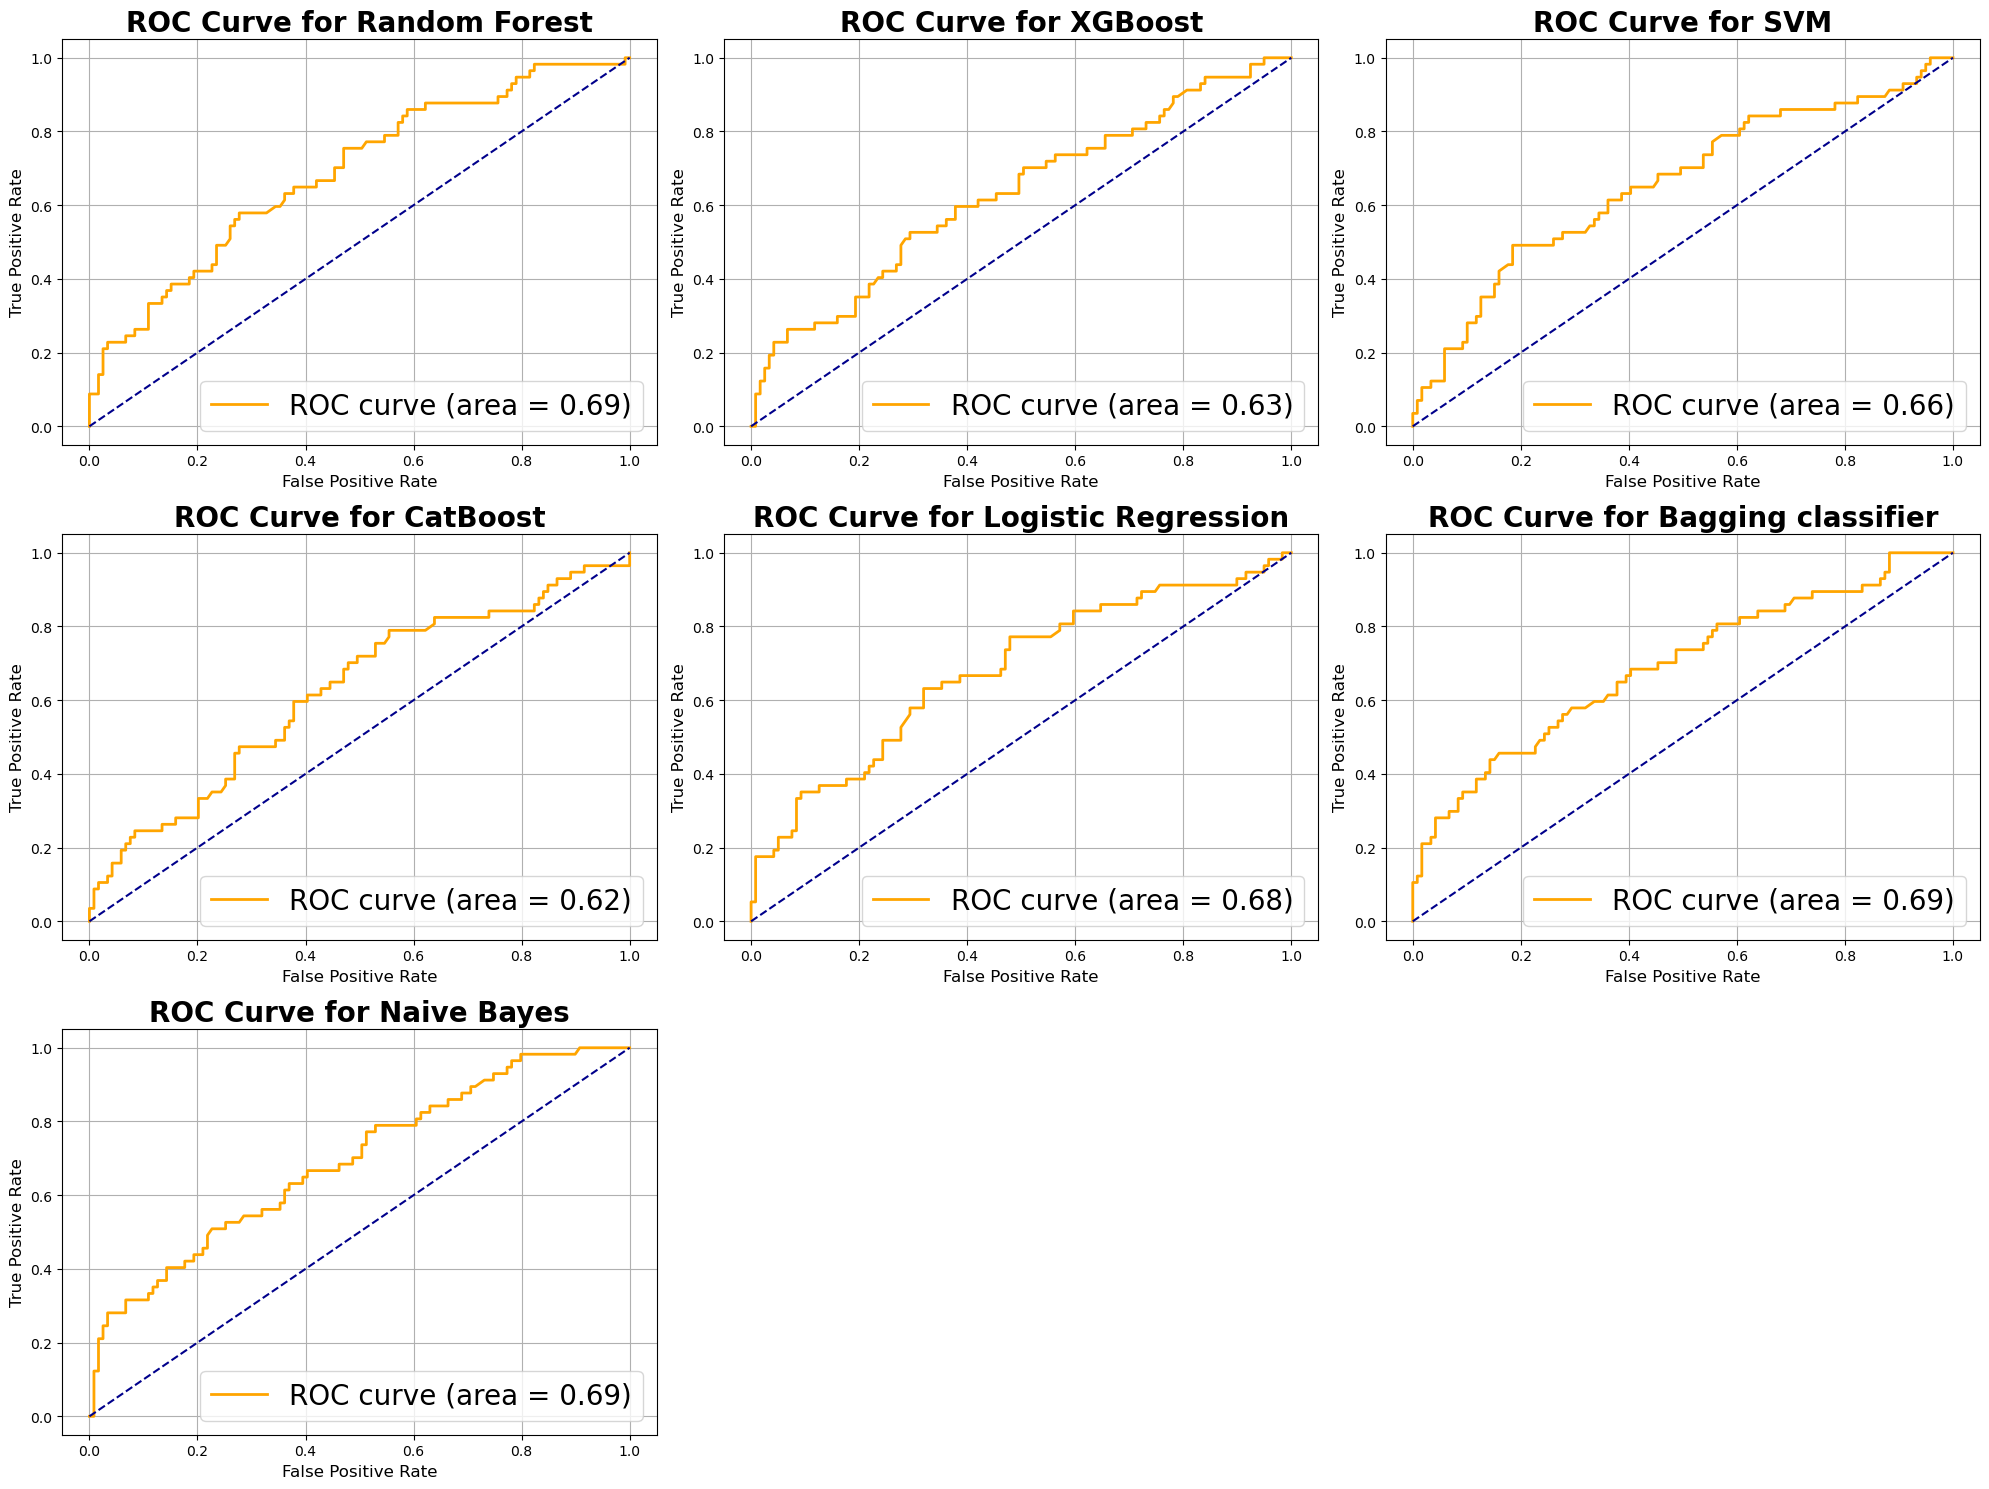

In [29]:
# Plot ROC Curves for Each Model
plt.figure(figsize=(20, 15))
models = ['Random Forest', 'XGBoost', 'SVM', 'CatBoost', 'Logistic Regression', 'Bagging classifier', 'Naive Bayes']
y_probs = [rf_y_prob, xgb_y_prob, svm_y_prob, catboost_y_prob, logreg_y_prob, bagging_y_prob, nb_y_prob]

for i, (model, y_prob) in enumerate(zip(models, y_probs)):
    plt.subplot(3, 3, i + 1)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve for {model}', fontsize=20, fontweight='bold')
    plt.legend(loc='lower right', fontsize=20)
    plt.grid(True)

plt.tight_layout()
plt.savefig('figures/roc_curves_surpervised_classifier.png')
plt.show()

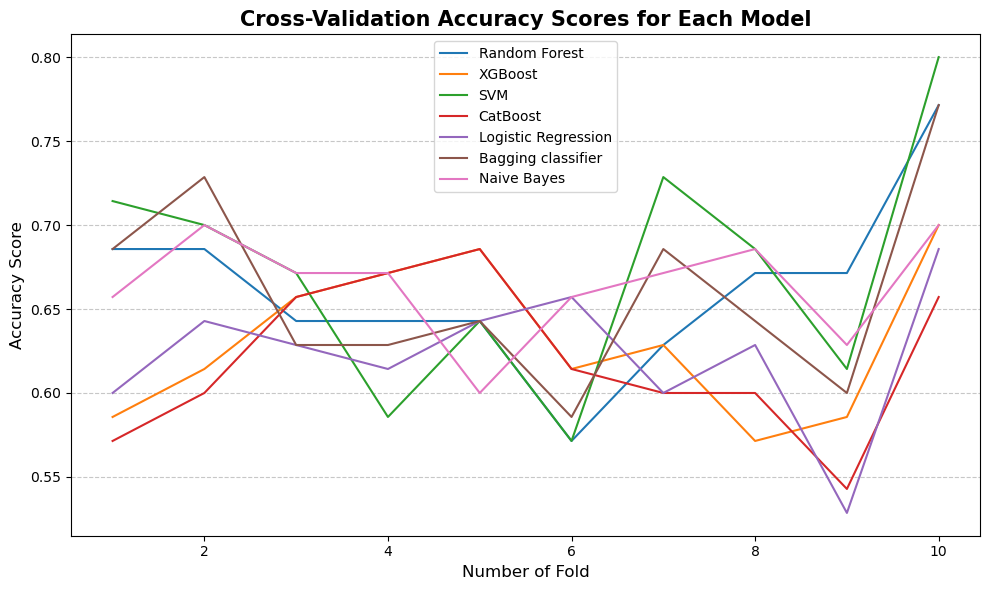

In [30]:
# Model Performance Comparison - Cross-Validation Accuracy
cv_results = {
    'Random Forest': cross_val_score(rf_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score)),
    'XGBoost': cross_val_score(xgb_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score)),
    'SVM': cross_val_score(svm_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score)),
    'CatBoost': cross_val_score(catboost_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score)),
    'Logistic Regression': cross_val_score(logreg_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score)),
    'Bagging classifier': cross_val_score(bagging_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score)),
    'Naive Bayes': cross_val_score(nb_pipeline, X_train, y_train, cv=kf, scoring=make_scorer(accuracy_score))
}

plt.figure(figsize=(10, 6))
for model, scores in cv_results.items():
    plt.plot(range(1, len(scores) + 1), scores, label=model)

plt.xlabel('Number of Fold', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Cross-Validation Accuracy Scores for Each Model', fontsize=15, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('figures/cross_val_supervised_classifiers.png')
plt.show()

### Step 5: SHAP

In [26]:
models = {
    'Random Forest': rf_pipeline.named_steps['randomforestclassifier'],
    'XGBoost': xgb_pipeline.named_steps['xgbclassifier'],
    'CatBoost': catboost_pipeline.named_steps['catboostclassifier']
}

for model_name, model in models.items():
    print(f"\nSHAP Feature Importance for {model_name}:")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(preprocessor.transform(X_test))
    shap.summary_plot(shap_values, preprocessor.transform(X_test), feature_names=preprocessor.get_feature_names_out())


KeyError: 'randomforestclassifier'